In [1]:
import sys, scipy
sys.path.append('./../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [30]:
zbin, Ns = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/cmass_sgc.nz_2', unpack=True)
zbin, Nn = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/cosmosis/dmass_cat/cmass_ngc.nz_2', unpack=True)
step = zbin[2]-zbin[1]
zcenter = zbin[:-1] + step/2.

In [31]:
int_nzs = scipy.integrate.simps(Ns**2, dx=step)
int_nzn = scipy.integrate.simps(Nn**2, dx=step)
nzs_ratio = int_nzs/int_nzn
print nzs_ratio
print int_nzs, int_nzn

int_nzs1 = scipy.integrate.simps(Ns, dx=step)
int_nzn1 = scipy.integrate.simps(Nn, dx=step)
nzs_ratio1 = int_nzs1/int_nzn1
print nzs_ratio1


0.9535466308866252
3.5659365790607374 3.739656209308887
1.0000126880382751


(0, 1)

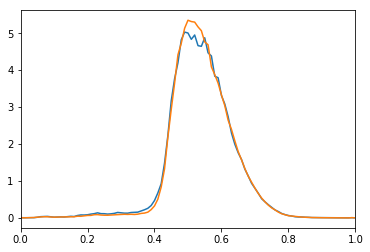

In [35]:
fig, ax = plt.subplots()
ax.plot(zbin, Ns)
ax.plot(zbin, Nn)
ax.set_xlim(0,1)

In [44]:
rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'

In [45]:
cov_mocks = np.genfromtxt('../data_txt/mocks/cov_mock_galaxy_DR12_CMASS_S_QPM_760.cov')
cov_mocks_ngc = np.genfromtxt('../data_txt/mocks/cov_mock_galaxy_DR12_CMASS_N_QPM_1000.cov')
cov_rescaled_mocks = np.genfromtxt('../data_txt/cmass/cov_rescaled_mocks_NG.txt')
print cov_rescaled_mocks.shape

(10, 10)


In [46]:
#meanr_sgc, xi_sgc, _ = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cmass_sgc_data = np.genfromtxt('../data_txt/cmass/npairs_cmass_sgc_bins10_binslop_05.txt')
_, meanr_sgc, _, xi_sgc, _, DD_sgc, RR_sgc, DR_sgc, npairs_sgc = [cmass_sgc_data[:,i] for i in range(9)]

#cov_cmass_s_1 = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')
#fisher_cmass_s = HFactor * np.linalg.inv(cov_cmass_s_1)
#cov_cmass_s = np.linalg.inv(fisher_cmass_s)
cov_cmass_s = cov_mocks.copy() #cov_an_cmass.copy()
xi_err_sgc = np.sqrt(cov_cmass_s.diagonal())


cmass_ngc_data1 = np.genfromtxt('../data_txt/cmass/npairs_cmass_ngc_bins10_binslop_05.txt')
_, meanr_ngc, _, xi_ngc, sigma_xi_ngc1, DD_ngc, RR_ngc, DR_ngc, npairs_ngc = [cmass_ngc_data1[:,i] for i in range(9)]
#meanr_ngc, xi_ngc, _ = np.loadtxt('../data_txt//acf_auto_cmass_ngc_sys_cp_nz_weight_nbin10_jk100.txt',unpack=True)
cov_cmass_n = cov_mocks_ngc.copy() #np.genfromtxt('../data_txt//acf_auto_cmass_ngc_sys_cp_nz_weight_nbin10_jk100.cov')* 1./HFactor
xi_err_ngc = np.sqrt(cov_cmass_n.diagonal())


#meanr_full, xi_full, _ = np.loadtxt('../data_txt//acf_auto_cmass_full_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
#cov_cmass_full = np.genfromtxt('../data_txt//acf_auto_cmass_full_sys_cp_nz_weight_nbins10_jk100.cov')*1./HFactor

DD_full = DD_sgc + DD_ngc
DR_full = DR_sgc + DR_ngc
RR_full = RR_sgc + RR_ngc

meanr_full = meanr_ngc.copy()
xi_full = (DD_full - 2*DR_full + RR_full)*1./RR_full
cov_cmass_full = np.linalg.inv(np.linalg.inv( cov_cmass_s ) + np.linalg.inv( cov_cmass_s ))
xi_err_full = np.sqrt(cov_cmass_full.diagonal())

#meanr_dmass, xi_dmass, _ = np.genfromtxt(rootdir+'/act//acf_auto_dmass_all_weight_pcut01_nbins10_jk100.txt', unpack=True) 
#cov_dmass = np.genfromtxt(rootdir+'/act//acf_auto_dmass_all_weight_pcut01_nbins10_jk100.cov')* 1./HFactor

dmass_data = np.genfromtxt('../data_txt/cmass/npairs_dmass_pcut_sysweight_bins10_binslop_05.txt')
_, meanr_dmass, _, xi_dmass, _, _, _, _, _ = [dmass_data[:,i] for i in range(9)]
cov_dmass = cov_rescaled_mocks.copy() #cov_an_dmass.copy()
xi_err_dmass = np.sqrt(cov_dmass.diagonal())

In [47]:
#cov_dmass = np.genfromtxt(rootdir+'/act//acf_auto_dmass_all_weight_pcut01_nbins10_jk100.cov')* 1./HFactor
#meanr_dmass, xi_dmass, _ = np.genfromtxt(rootdir+'/act//acf_auto_dmass_all_weight_pcut01_nbins10_jk100.txt', unpack=True) 
cov = cov_cmass_s + cov_dmass
invcov = np.linalg.inv(cov)
datav = xi_dmass - xi_sgc
chisqr = np.dot(np.dot(datav, invcov), datav.T) 
print 'chisqr/dof between SGC and DMASS', chisqr, '/10'


cov = cov_cmass_n + cov_dmass
invcov = np.linalg.inv(cov)
datav = xi_dmass - xi_ngc
chisqr_dn = np.dot(np.dot(datav, invcov), datav.T) 
print 'chisqr/dof between NGC and DMASS', chisqr_dn, '/10'


cov = cov_cmass_n + cov_cmass_n
invcov = np.linalg.inv(cov)
datav = xi_sgc - xi_ngc
chisqr_sn = np.dot(np.dot(datav, invcov), datav.T) 
print 'chisqr/dof between NGC and SGC', chisqr_sn, '/10'

chisqr/dof between SGC and DMASS 2.579001510259711 /10
chisqr/dof between NGC and DMASS 10.95656684269568 /10
chisqr/dof between NGC and SGC 10.607006619495527 /10


In [48]:
F_ns = np.linalg.inv(cov_cmass_n + cov_cmass_s)
F_nd = np.linalg.inv(cov_cmass_n + cov_dmass)
F_sd = np.linalg.inv(cov_cmass_s + cov_dmass)

In [43]:
""""""
DAT = np.loadtxt(rootdir+'/act//acf_auto_dmass_all_weight_pcut01_nbins10_jk100.txt')
meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

DAT7 = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt')
meanr7, xi7, xi_err7 = [DAT7[:,i] for i in range(3)]

DAT11 = np.loadtxt('../data_txt//acf_auto_cmass_ngc_sys_cp_nz_weight_nbin10_jk100.txt')
meanr11, xi11, xi_err11 = [DAT11[:,i] for i in range(3)]



cov_cmass_n = np.genfromtxt(rootdir+'/act//acf_auto_dmass_all_weight_pcut01_nbins10_jk100.cov')
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')
cov_dmass = np.genfromtxt('../data_txt/acf_auto_dmass_spt_nbins10_jk100.cov')

HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)
HFn = HF(100, 10)
HFs = HF(100, 10)
HFd = HF(100, 10)

print HFn

F_ns = HFn * HFs * np.linalg.inv(cov_cmass_n + cov_cmass_s)
F_nd = HFn * HFd * np.linalg.inv(cov_cmass_n + cov_dmass)
F_sd = HFs * HFd * np.linalg.inv(cov_cmass_s + cov_dmass)
""""""

0.888888888889


''

### 10 bins 

Equations for brel test

In [49]:
def brelchisqr(xi, xi2, invcov, brelsqr):
    DiffVector = xi2 - brelsqr*xi
    chi2 = np.dot( np.dot( DiffVector , invcov), DiffVector )
    return chi2

def find_nearest(array, value, brell):
    
    ind_min = array.argmin()
    array1 = np.asarray(array[:ind_min])
    idx1 = (np.abs(array1 - value)).argmin()
    
    array2 = np.asarray(array[ind_min:])
    idx2 = (np.abs(array2 - value)).argmin()
    
    return brell[:ind_min][idx1], brell[ind_min], brell[ind_min:][idx2]


def brel_chisqr_fitting(xi1, xi2, Fisher, verbose=False):
    
    brelsqr = np.linspace(0.8, 1.2, 5000)   
    brelarr = np.sqrt(brelsqr) 
    chisqr_result = np.zeros(brelsqr.size)
    
    i=0
    for b in brelsqr:
        chisqr_result[i] = brelchisqr(xi1, xi2, Fisher, b)
        i+=1   
        
    minarg = chisqr_result.argmin()
    chisqr_min = chisqr_result.min()
    brel = np.sqrt(brelsqr[minarg])
    
    b_cmass = 2.0
    db = b_cmass * (1. - 1./brel)
    
       
    b_cmass = 2.0

    br1, brmin, br2 = find_nearest( chisqr_result, chisqr_min + 1,brelarr )
    err_brel = np.abs(br1-br2)/2.
    err_db = err_brel *b_cmass
    if verbose : print 'err db, db / br1, brmin, br2 :', err_db, db, br1, brmin, br2  
    #return err_db, db, chisqr_result
    return err_brel, brmin, chisqr_result
    

In [50]:
theta_th, w_theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, w_theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)
#theta_th, w_theory = np.loadtxt('../data_txt/acf_cmass_theory.txt', unpack=True)

In [51]:
from scipy.interpolate import interp1d

w_theory_ngc = interp1d(theta_th, w_theory, kind='cubic')
w_theory_ngc = w_theory_ngc(meanr_full)

w_theory_sgc = interp1d(theta_th, w_theory_sgc, kind='cubic')
w_theory_sgc = w_theory_sgc(meanr_full)

In [52]:
mock_n = np.random.multivariate_normal( w_theory_ngc, cov_cmass_n, size=1000 )
mock_s = np.random.multivariate_normal( w_theory_sgc, cov_cmass_s, size=1000 )
mock_d = np.random.multivariate_normal( w_theory_sgc, cov_dmass, size=1000 )

<Container object of 3 artists>

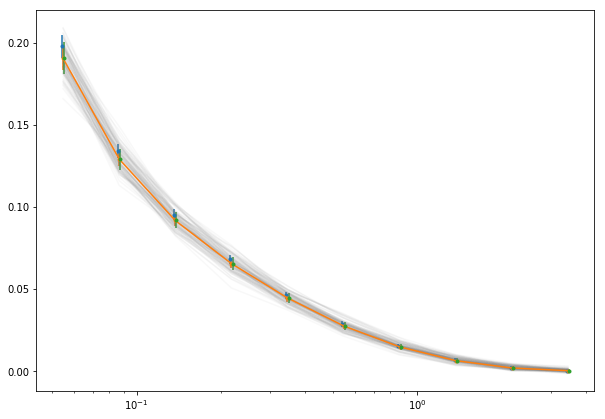

In [53]:
fig, ax = plt.subplots(figsize=(10,7))
for i in range(100): 
    ax.semilogx(meanr_full, mock_d[i], color='grey', alpha = 0.05)
ax.errorbar(meanr_full*0.99, w_theory_ngc, yerr=np.sqrt(cov_cmass_n.diagonal()), fmt='.')
ax.errorbar(meanr_full, w_theory_sgc, yerr=np.sqrt(cov_cmass_s.diagonal()), fmt='.-')
ax.errorbar(meanr_full*1.01, w_theory_sgc, yerr=np.sqrt(cov_dmass.diagonal()), fmt='.')

In [54]:
brel_ns_hist = np.zeros(1000)
chisqr_array_ns = np.zeros((1000, 5000))
brel_sd_hist = np.zeros(1000)
chisqr_array_sd = np.zeros((1000, 5000))

brel_nd_hist = np.zeros(1000)
chisqr_array_nd = np.zeros((1000, 5000))

#brel_ns_nzs_ratio = np.zeros(5000)
#chisqr_array_ns_nzs_ratio = np.zeros((5000, 5000))

for i in range(1000):
    _, brel_ns_hist[i], chisqr_array_ns[i] = brel_chisqr_fitting(mock_s[i], mock_n[i], F_ns)
    _, brel_nd_hist[i], chisqr_array_nd[i] = brel_chisqr_fitting(mock_d[i], mock_n[i], F_nd)
    _, brel_sd_hist[i], chisqr_array_sd[i] = brel_chisqr_fitting(mock_d[i], mock_s[i], F_sd)
    #_, brel_ns[i], chisqr_array_ns[i] = brel_chisqr_fitting(mock_s[i], w_theory, F_ns)
    #_, brel_nd[i], chisqr_array_nd[i] = brel_chisqr_fitting(mock_d[i], w_theory, F_nd)
    #_, brel_sd[i], chisqr_array_sd[i] = brel_chisqr_fitting(mock_d[i], mock_s[i], F_sd)    
    #_, brel_ns_nzs_ratio[i], chisqr_array_ns_nzs_ratio[i] = brel_chisqr_fitting(mock_s[i], nzs_ratio*mock_n[i], F_sd)
    print i, '\r',
    #brel_n.append(brel_ns)
    #c3hisqr_array_n.append(chisqr_result_ns)
#err_db_nd, db_nd, chisqr_result_nd = brel_chisqr_fitting(xi,  xi11, F_nd)
#err_db_sd, db_sd, chisqr_result_sd = brel_chisqr_fitting(xi,  xi7, F_sd)
#err_db_ns_nzs_ratio, db_ns_nzs_ratio, chisqr_result_ns_nzs_ratio = brel_chisqr_fitting(xi7,  xi11*nzs_ratio, F_ns)

In [55]:
bshift_ns= 1./np.mean(brel_ns_hist)
bshift_nd= 1./np.mean(brel_nd_hist)
bshift_sd= 1./np.mean(brel_sd_hist)
print bshift_ns, bshift_nd, bshift_sd

0.9837365533591043 0.9866998958178302 1.0057395210306586


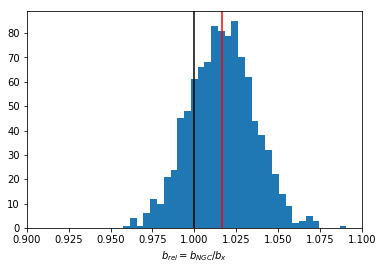

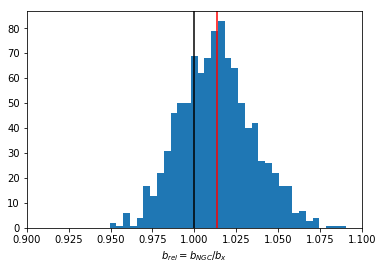

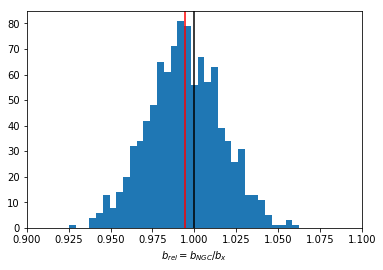

In [63]:
bins, bs = np.linspace(0.8, 1.2, 100, retstep=True)
bincent = bins[:-1] + bs/2.

fig, ax = plt.subplots()
N,_,_ = ax.hist(brel_ns_hist, bins = bins)
meanv = np.sum(bincent * N)/np.sum(N)

meanv = np.mean(brel_ns_hist)
ax.axvline(x = 1.0, color='k')
ax.axvline(x=meanv, color='r')
ax.set_xlim(0.9, 1.1)
ax.set_xlabel('$b_{rel} = b_{NGC} /b_x$')

fig, ax = plt.subplots()
N,_,_ = ax.hist(brel_nd_hist, bins = bins)
meanv = np.sum(bincent * N)/np.sum(N)

meanv = np.mean(brel_nd_hist)
ax.axvline(x = 1.0, color='k')
ax.axvline(x=meanv, color='r')
ax.set_xlim(0.9, 1.1)
ax.set_xlabel('$b_{rel} = b_{NGC} /b_x$')

fig, ax = plt.subplots()
N,_,_ = ax.hist(brel_sd_hist, bins = bins)
meanv = np.sum(bincent * N)/np.sum(N)

meanv = np.mean(brel_sd_hist)
ax.axvline(x = 1.0, color='k')
ax.axvline(x=meanv, color='r')
ax.set_xlim(0.9, 1.1)
ax.set_xlabel('$b_{rel} = b_{NGC} /b_x$')


In [72]:
#err_brel_ns, brel_ns, chisqr_result_ns = brel_chisqr_fitting(xi_ngc, xi_sgc, F_ns, verbose=True)
#err_brel_nd, brel_nd, chisqr_result_nd = brel_chisqr_fitting(xi_ngc,  xi_dmass, F_nd, verbose=True)
#err_brel_sd, brel_sd, chisqr_result_sd = brel_chisqr_fitting(xi_sgc,  xi_dmass, F_sd, verbose=True)

err_brel_ns, brel_ns, chisqr_result_ns = brel_chisqr_fitting(xi_sgc, xi_ngc, F_ns, verbose=True)
err_brel_nd, brel_nd, chisqr_result_nd = brel_chisqr_fitting(xi_dmass,  xi_ngc, F_nd, verbose=True)
err_brel_sd, brel_sd, chisqr_result_sd = brel_chisqr_fitting(xi_dmass,  xi_sgc, F_sd, verbose=True)
err_brel_ns_nzs_ratio, brel_ns_nzs_ratio, chisqr_result_ns_nzs_ratio = brel_chisqr_fitting(xi_sgc,  xi_ngc*nzs_ratio, F_ns, verbose=True)

#err_brel_ns, brel_ns, chisqr_result_ns = brel_chisqr_fitting(theory_sgc_interp, theory_interp, F_ns)
#err_brel_nd, brel_nd, chisqr_result_nd = brel_chisqr_fitting(xi,  theory_interp, F_nd)
#err_brel_sd, brel_sd, chisqr_result_sd = brel_chisqr_fitting(xi,  theory_sgc_interp, F_sd)
#err_brel_ns_nzs_ratio, brel_ns_nzs_ratio, chisqr_result_ns_nzs_ratio = brel_chisqr_fitting(theory_sgc_interp,  theory_interp*nzs_ratio, F_ns)

err db, db / br1, brmin, br2 : 0.03473365212725121 0.09006805181396738 1.0296659858461295 1.047157728263308 1.0643996379733807
err db, db / br1, brmin, br2 : 0.04276113337391818 0.09692973142104644 1.0293162285613084 1.0509333433564831 1.0720773619352266
err db, db / br1, brmin, br2 : 0.04473843867699523 0.007202355197606813 0.9809956526377163 1.0036141929494908 1.0257340913147115
err db, db / br1, brmin, br2 : 0.03557064676142452 0.04414341994649362 1.0046102967666983 1.0225698654986686 1.0401809435281228


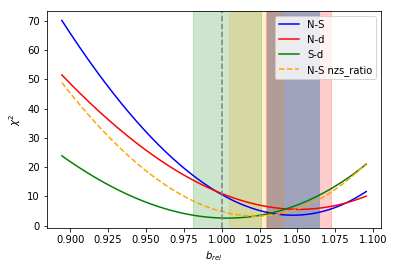

In [73]:
fig, ax = plt.subplots()

brelsqr = np.linspace(0.8, 1.2, 5000) 
b_n = 2.0
brel = np.sqrt(brelsqr)
dbarray = b_n*(1-brel)

ax.plot(brel, chisqr_result_ns, '-b', label='N-S')
#ax.plot(brel, chisqr_result_ns_new, '-m', label='N-S new')
ax.plot(brel, chisqr_result_nd, '-r',label='N-d')
ax.plot(brel, chisqr_result_sd, '-g',label='S-d')
ax.plot(brel, chisqr_result_ns_nzs_ratio, color='orange', ls='--',label='N-S nzs_ratio')

#ax.errorbar(db_ns, chisqr_min_ns, xerr =err_brel_ns *b_cmass)
#ax.errorbar(db_nd, chisqr_min_nd, xerr =err_brel_nd *b_cmass)
#ax.errorbar(db_sd, chisqr_min_sd, xerr =err_brel_sd *b_cmass)

#ax.axvline(db_ns, lw = err_brel_ns *b_cmass, alpha = 0.5)
ax.axvspan(brel_ns-err_brel_ns, brel_ns+err_brel_ns, alpha=0.99, color='skyblue')

ax.axvspan(brel_sd-err_brel_sd, brel_sd+err_brel_sd, alpha=0.2, color='green')
ax.axvspan(brel_ns_nzs_ratio-err_brel_ns_nzs_ratio, brel_ns_nzs_ratio+err_brel_ns_nzs_ratio, alpha=0.2, color='orange')
ax.axvspan(brel_nd-err_brel_nd, brel_nd+err_brel_nd, alpha=0.2, color='red')
ax.axvline(x=1.0, color = 'grey', ls='--')
#ax.axvline(x=0, color = 'grey', ls='--')

ax.set_xlabel(r'$b_{rel}$')
ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
#ax.axhline(y = chisqr_min_ns+1)
#ax.axhline(y = chisqr_min_nd+1)
#ax.axhline(y = chisqr_min_sd+1)

#chinull_ns= brelchisqr(xi7, xi11, F_ns, 1)
#chinull_nd= brelchisqr(xi, xi11, F_nd, 1)
#chinull_sd= brelchisqr(xi, xi7, F_sd, 1)
#print chinull_ns
#from scipy.stats.distributions import chi2

#print chi2.sf(chisqr_min_ns,9), chi2.sf(chisqr_min_nd,9), chi2.sf(chisqr_min_sd,9)
#print chi2.sf(chinull_ns,9), chi2.sf(chinull_nd,9), chi2.sf(chinull_sd,9)

ngc-sgc (blue) : 1.03012733443+-0.0170843816146


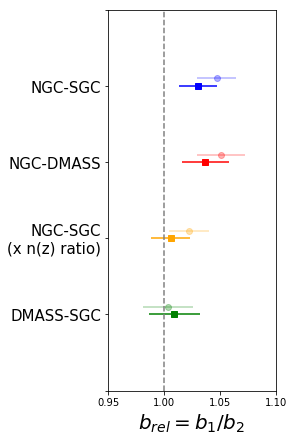

In [74]:
fig, ax = plt.subplots(figsize = (3,7))

brelsqr = np.linspace(0.8, 1.2, 5000) 
b_n = 2.0
brel = np.sqrt(brelsqr)
dbarray = b_n*(1-brel)

ax.errorbar(brel_ns, 4.1, xerr =err_brel_ns, fmt='-o', color='blue', alpha = 0.3)
ax.errorbar(brel_nd, 3.1, xerr =err_brel_nd, fmt='-o', color = 'red', alpha = 0.3)
ax.errorbar(brel_sd, 1.1, xerr =err_brel_sd, fmt='-o', color = 'green', alpha = 0.3)
ax.errorbar(brel_ns_nzs_ratio, 2.1, xerr = err_brel_ns_nzs_ratio, fmt='-o', color='orange', alpha = 0.3)

ax.errorbar(brel_ns*bshift_ns, 4, xerr =err_brel_ns*bshift_ns, fmt='-s', color='blue')
ax.errorbar(brel_nd*bshift_nd, 3, xerr =err_brel_nd*bshift_nd, fmt='-s', color = 'red')
ax.errorbar(brel_sd*bshift_sd, 1, xerr =err_brel_sd*bshift_sd, fmt='-s', color = 'green')
ax.errorbar(brel_ns_nzs_ratio*bshift_ns, 2, xerr = err_brel_ns_nzs_ratio*bshift_ns, fmt='-s', color='orange')

#ax.axvline(db_ns, lw = err_brel_ns *b_cmass, alpha = 0.5)
#ax.axvspan(brel_ns-err_brel_ns, brel_ns+err_brel_ns, alpha=0.99, color='skyblue')

#ax.axvspan(brel_sd-err_brel_sd, brel_sd+err_brel_sd, alpha=0.2, color='green')
#ax.axvspan(brel_ns_nzs_ratio-err_brel_ns_nzs_ratio, brel_ns_nzs_ratio+err_db_ns_nzs_ratio, alpha=0.2, color='orange')
#ax.axvspan(brel_nd-err_brel_nd, brel_nd+err_brel_nd, alpha=0.2, color='red')
ax.axvline(x=1.0, color = 'grey', ls='--')
#ax.axvline(x=0, color = 'grey', ls='--')

ax.set_xlabel(r'$b_{rel} = b_{1}/b_{2}$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
ax.set_xlim(0.95, 1.1)
#ax.axhline(y = chisqr_min_ns+1)
#ax.axhline(y = chisqr_min_nd+1)
#ax.axhline(y = chisqr_min_sd+1)

ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels(['','DMASS-SGC','NGC-SGC\n(x n(z) ratio)', 'NGC-DMASS', 'NGC-SGC' ,''], fontsize = 15) 
#print chi2.sf(chisqr_min_ns,9), chi2.sf(chisqr_min_nd,9), chi2.sf(chisqr_min_sd,9)
#print chi2.sf(chinull_ns,9), chi2.sf(chinull_nd,9), chi2.sf(chinull_sd,9)


print 'ngc-sgc (blue) : {}+-{}'.format(brel_ns*bshift_ns, err_brel_ns*bshift_ns)
#print 'nzcorrect ngc-sgc (orange) : {}+-{}'.format(brel_ns_nzs_ratio*bshift_ns, err_brel_ns_nzs_ratio*bshift_ns)